##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(vegan)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)

Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
#print(physeq)
#sample.data = read.csv(file = "/var/seq_data/priming_exp/data/allsample_metadata_nomock.csv")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
#print(sample.data)
physeq = merge_phyloseq(physeq,sample.data)
#print(physeq)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C100","13C100")), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3027 taxa and 145 samples ]
sample_data() Sample Data:       [ 145 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3027 tips and 3026 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distnaces with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08243435 
Run 1 stress 0.1060092 
Run 2 stress 0.08362174 
Run 3 stress 0.1596808 
Run 4 stress 0.08309921 
Run 5 stress 0.08287119 
... procrustes: rmse 0.006873122  max resid 0.06800208 
Run 6 stress 0.08390266 
Run 7 stress 0.08243325 
... New best solution
... procrustes: rmse 0.0002693563  max resid 0.002190171 
*** Solution reached


NULL


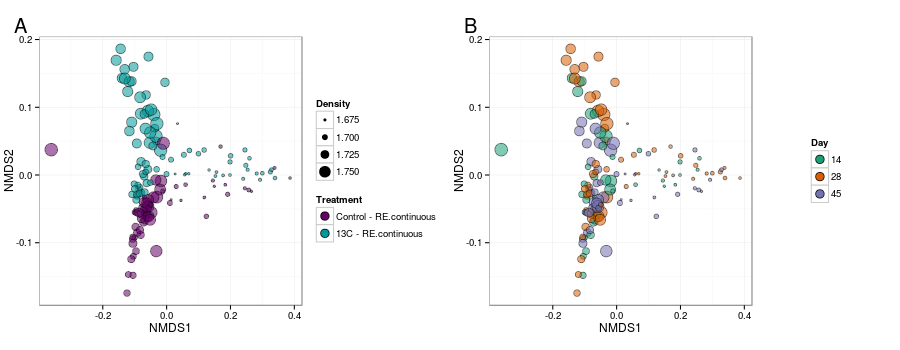

In [8]:
%%R -w 900 -h 350

colours = c("#660066", "#009999", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "13C100"),
                            labels=c("Control - RE.continuous", "13C - RE.continuous"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2))
p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p2 = p2 + scale_fill_brewer(palette="Dark2")
p2 = p2 + guides(alpha = FALSE, size = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20))


gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [9]:
%%R -w 1000 -h 350
pdf("figs/ordination_100.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.2, 1), ncol=2)
dev.off()

png 
  2 


In [10]:
FileLink("figs/ordination_100.pdf")

/home/ashley/priming_exp/figs/ordination_100.pdf

In [11]:
%%R 
png("figs/ordination_100.png", width = 12, height = 5, units = "in", res = 600)
grid.arrange(p1, p2, widths = c(1.2, 1), ncol=2)
dev.off()

png 
  2 


In [12]:
FileLink("figs/ordination_100.png")

/home/ashley/priming_exp/figs/ordination_100.png

In [13]:
%%R
physeq.heavy = prune_samples(sample_data(physeq.PE.thresh)$Density >= 1.725, physeq.PE.thresh)

In [14]:
%%R
wunif.dist.heavy = distance(physeq.heavy, method = "unifrac", weighted = TRUE)

In [15]:
%%R
#convert physeq object to a dataframe for adonis test
df = sample_data(physeq.heavy)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
df = data.frame(df)
head(df)

                           Sample FractionNum Bulk Control CC X100 X700 H2O Day
12C.100.14.05.11 12C.100.14.05.11          11    0       1  0    1    0   0  14
12C.100.28.03.03 12C.100.28.03.03           3    0       1  0    1    0   0  28
12C.100.14.05.05 12C.100.14.05.05           5    0       1  0    1    0   0  14
12C.100.28.03.04 12C.100.28.03.04           4    0       1  0    1    0   0  28
12C.100.45.01.04 12C.100.45.01.04           4    0       1  0    1    0   0  45
12C.100.28.03.07 12C.100.28.03.07           7    0       1  0    1    0   0  28
                 Density         rep contolVlabel Treatment
12C.100.14.05.11  1.7253                  control    12C100
12C.100.28.03.03  1.7603 control_rep      control    12C100
12C.100.14.05.05  1.7592                  control    12C100
12C.100.28.03.04  1.7581 control_rep      control    12C100
12C.100.45.01.04  1.7548                  control    12C100
12C.100.28.03.07  1.7428 control_rep      control    12C100


In [16]:
%%R
#to test if community composition in heavy fractions is different between treatments
adonis.wunif.heavy = adonis(wunif.dist.heavy ~ Treatment, data = df, permutations = 1000)
adonis.wunif.heavy


Call:
adonis(formula = wunif.dist.heavy ~ Treatment, data = df, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Treatment  1   0.71619 0.71619  41.257 0.42421 0.000999 ***
Residuals 56   0.97211 0.01736         0.57579             
Total     57   1.68831                 1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Test if there is a time signature in the heavy fractions of the 13C treatment

In [17]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.C13 = prune_samples((physeq.md$Treatment %in% c("13C100"))& (physeq.md$Bulk == 0), physeq)
physeq.C13.snorm = transform_sample_counts(physeq.C13, function(x) x/sum(x))
physeq.C13.thresh = filter_taxa(physeq.C13.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.C13)
print(physeq.C13.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2695 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 2695 tips and 2694 internal nodes ]


In [18]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.C13.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [19]:
%%R
nmds = ordinate(physeq.C13.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.05796278 
Run 1 stress 0.05796611 
... procrustes: rmse 0.0004752291  max resid 0.003141283 
*** Solution reached


In [20]:
%%R
physeq.thresh.C13heavy = prune_samples(sample_data(physeq.C13.thresh)$Density >= 1.725, physeq.C13.thresh)

In [21]:
%%R
wunif.dist.C13heavy = distance(physeq.thresh.C13heavy, method = "unifrac", weighted = TRUE)

In [22]:
%%R
#convert physeq object to a dataframe for adonis test
df3 = sample_data(physeq.thresh.C13heavy)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
df3 = data.frame(df3)
head(df3)

                           Sample FractionNum Bulk Control CC X100 X700 H2O Day
13C.100.28.07.07 13C.100.28.07.07           7    0       0  0    1    0   0  28
13C.100.28.06.04 13C.100.28.06.04           4    0       0  0    1    0   0  28
13C.100.45.03.07 13C.100.45.03.07           7    0       0  0    1    0   0  45
13C.100.45.03.08 13C.100.45.03.08           8    0       0  0    1    0   0  45
13C.100.28.07.11 13C.100.28.07.11          11    0       0  0    1    0   0  28
13C.100.45.03.04 13C.100.45.03.04           4    0       0  0    1    0   0  45
                 Density          rep contolVlabel Treatment
13C.100.28.07.07  1.7461 label_rep_07        label    13C100
13C.100.28.06.04  1.7657 label_rep_06        label    13C100
13C.100.45.03.07  1.7461                     label    13C100
13C.100.45.03.08  1.7406                     label    13C100
13C.100.28.07.11  1.7253 label_rep_07        label    13C100
13C.100.45.03.04  1.7657                     label    13C100


In [23]:
%%R
#to test if community composition in heavy fractions is different between days
adonis.wunif.heavy = adonis(wunif.dist.C13heavy ~ Day, data = df3, permutations = 1000)
adonis.wunif.heavy


Call:
adonis(formula = wunif.dist.C13heavy ~ Day, data = df3, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2   Pr(>F)   
Day        1   0.08599 0.085985  6.0791 0.16849 0.003996 **
Residuals 30   0.42433 0.014144         0.83151            
Total     31   0.51031                  1.00000            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
